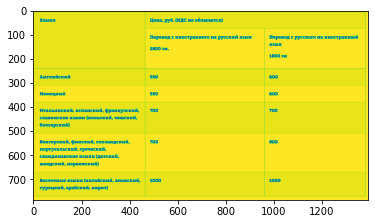

In [107]:
import pytesseract
import cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
img = cv2.imread("table2.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.show()

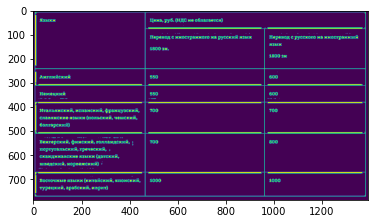

In [108]:
BLOCK_SIZE = 25

filtered = cv2.adaptiveThreshold(~img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                 cv2.THRESH_BINARY, BLOCK_SIZE, 0)
plt.imshow(filtered)
plt.show()

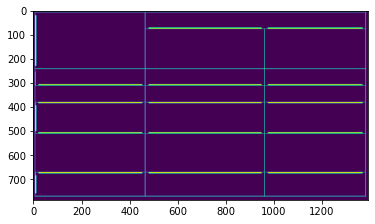

In [109]:
#flag define horizontal/vertical
def erase(filtered, flag):
    scale = 15
    image = filtered.copy()
    
    if flag:
        size = (image.shape[1] // scale, 1)
    else:
        size = (1, image.shape[0] // scale)
        
    structure = cv2.getStructuringElement(cv2.MORPH_RECT, size)
    
    cv2.erode(image, structure, image, (-1, -1))
    cv2.dilate(image, structure, image, (-1, -1))
        
    return image

horizontal = erase(filtered, True)
vertical = erase(filtered, False)
mask = horizontal + vertical
plt.imshow(mask)
plt.show()

In [110]:
# исправить проход по всему изображению
extra = 20 # дорисовка линий d 20px
h_lines = []
for j in range(len(horizontal)):
    flag_i = True
    flag_k = True
    i = 0
    k = len(horizontal[0])-1
    while i<k and (flag_i or flag_k):
        if flag_i and horizontal[j][i] == 255:
            flag_i = False
            x1 = i
            y1 = j
        if flag_k and horizontal[j][k] == 255:
            flag_k = False
            x2 = k
            y2 = j
        i += 1
        k -= 1
    if (not flag_i and not flag_k):
        h_lines.append((x1 - extra, y1, x2 + extra, y2))

v_lines = []
for j in range(len(vertical[0])):
    flag_i = True
    flag_k = True
    i = 0
    k = len(vertical)-1
    while i<k and (flag_i or flag_k):
        if flag_i and vertical[i][j] == 255:
            flag_i = False
            x1 = j
            y1 = i
        if flag_k and vertical[k][j] == 255:
            flag_k = False
            x2 = j
            y2 = k
        i += 1
        k -= 1
    if (not flag_i and not flag_k):
        v_lines.append((x1, y1 - extra, x2, y2 + extra))

In [111]:
delta = 5
true_h_lines = []
for i in range(len(h_lines)-1):
    x1, y1, x2, y2 = h_lines[i]
    x3, y3, x4, y4 = h_lines[i+1]
    if (y3-y1 > delta):
        true_h_lines.append(h_lines[i])
if (len(h_lines)-1 != 0):
    true_h_lines.append(h_lines[len(h_lines)-1])

true_v_lines = []
for i in range(len(v_lines)-1):
    x1, y1, x2, y2 = v_lines[i]
    x3, y3, x4, y4 = v_lines[i+1]
    if (x3-x1 > delta):
        true_v_lines.append(v_lines[i])
if (len(v_lines)-1 != 0):
    true_v_lines.append(v_lines[len(v_lines)-1])

In [112]:
print(true_h_lines)
print(true_v_lines)

[(-11, 8, 1403, 8), (446, 77, 1403, 77), (-11, 243, 1403, 243), (-11, 312, 1403, 312), (2, 385, 1389, 385), (-11, 511, 1403, 511), (5, 676, 1385, 676), (-11, 771, 1403, 771)]
[(13, 2, 13, 778), (466, -12, 466, 792), (962, 57, 962, 792), (1382, -12, 1382, 792)]


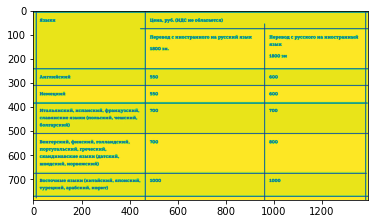

In [113]:
#проверка отрисовки
img_2 = img.copy()
for i in range(len(true_h_lines)):
    x1, y1, x2, y2 = true_h_lines[i]
    cv2.line(img_2, (x1, y1), (x2, y2), (0, 0, 255), 2)
for i in range(len(true_v_lines)):
    x1, y1, x2, y2 = true_v_lines[i]
    cv2.line(img_2, (x1, y1), (x2, y2), (0, 0, 255), 2)
plt.imshow(img_2)
plt.show()

In [114]:
intersections = []
for i in true_h_lines:
    intersection = []
    for j in true_v_lines:
        x1, y1, x2, y2 = i
        x3, y3, x4, y4 = j
        if (y1 >= y3 - delta and y1 <= y4 + delta and x3 >= x1 - delta and x3 <= x2 + delta):
            intersection.append((x3, y1))
        elif (y1 >= y3 - delta and y1 <= y4 + delta):
            intersection.append((None, y1))
        elif (x3 >= x1 - delta and x3 <= x2 + delta):
            intersection.append((x3, None))
        else:
            intersection.append((None, None))
    intersections.append(intersection)
intersections

[[(13, 8), (466, 8), (962, None), (1382, 8)],
 [(None, 77), (466, 77), (962, 77), (1382, 77)],
 [(13, 243), (466, 243), (962, 243), (1382, 243)],
 [(13, 312), (466, 312), (962, 312), (1382, 312)],
 [(13, 385), (466, 385), (962, 385), (1382, 385)],
 [(13, 511), (466, 511), (962, 511), (1382, 511)],
 [(13, 676), (466, 676), (962, 676), (1382, 676)],
 [(13, 771), (466, 771), (962, 771), (1382, 771)]]

In [115]:
table_cells = []
table_mask_h = set()
table_mask_v = set()
for i in range(len(intersections)-1):
    for j in range(len(intersections[0])-1):
        x, y = intersections[i][j]
        if (x == None or y == None):
            if (x is not None and y is None):
                table_mask_h.add((i, j))
            if (x is None and y is not None):
                table_mask_v.add((i, j))
            continue
        k = i+1
        while k <= len(intersections)-1:
            x1, y1 = intersections[k][j]
            if (x1 is None or y1 is None):
                k+=1
                continue
            d = j + 1
            while d <= len(intersections[0])-1:
                x2, y2 = intersections[k][d]
                if (y2 is None or x2 is None):
                    d += 1
                    continue
                x3, y3 = intersections[i][d] 
                if (x3 is not None and y3 is not None):
                    cell = (intersections[i][j], intersections[k][d])
                    table_cells.append(cell)
                    d = len(intersections[0])
                    k = len(intersections)
                d+=1
            k+=1
table_cells

[((13, 8), (466, 243)),
 ((466, 8), (1382, 77)),
 ((466, 77), (962, 243)),
 ((962, 77), (1382, 243)),
 ((13, 243), (466, 312)),
 ((466, 243), (962, 312)),
 ((962, 243), (1382, 312)),
 ((13, 312), (466, 385)),
 ((466, 312), (962, 385)),
 ((962, 312), (1382, 385)),
 ((13, 385), (466, 511)),
 ((466, 385), (962, 511)),
 ((962, 385), (1382, 511)),
 ((13, 511), (466, 676)),
 ((466, 511), (962, 676)),
 ((962, 511), (1382, 676)),
 ((13, 676), (466, 771)),
 ((466, 676), (962, 771)),
 ((962, 676), (1382, 771))]

In [116]:
#flag define horizontal/vertical
def recognise(table_cells, flag):
    mult = 3
    data = []
    stripe = []
    
    pred, current = -1, -1
    
    if (len(table_cells) != 0):
        (y1, x1), (y2, x2) = table_cells[0]
        
        if flag:
            pred = x1
        else:
            pred = y1

    for i in range(len(table_cells)):
        (y1, x1), (y2, x2) = table_cells[i]
        
        table_roi = img[x1:x2, y1:y2]
        out = pytesseract.image_to_string(table_roi, lang='rus')
    
        if flag:
            current = x1
        else:
            current = y1
            
        if pred == current:
            stripe.append(out[:-1])
        else:
            data.append(stripe)
            stripe = [out[:-1]]

        #plt.imshow(table_roi)
        #plt.show()
        pred = current
    data.append(stripe)
    return data

In [117]:
rows = recognise(table_cells, True)
print(rows)
#table_cells.sort()
#cols = recognise(table_cells, False)
#print(cols)

[['Языки', 'Цена, руб. (НДС не облагается)'], ['Перевод с иностранного на русский язык\n\n1800 зн.', 'Перевод с русского на иностранный\n\nязык\n\n1800 зн'], ['Английский', '550', '600'], ['Немецкий', '550', '600'], ['Итальянский, испанский, французский,\nславянские языки (польский, чешский,\n\nболгарский)', '700', '700'], ['Венгерский, финский, голландский,\nпортугальский, греческий,\nскандинавские языки (датский,\n\nшведский, норвежский)', '700', '800'], ['Восточные языки (китайский, японский,\n\nтурецкий, арабский, иврит)', '1000', '1000']]


In [118]:
for tup in table_mask_h:
    i, j = tup
    rows[i].insert(j, rows[i][j-1])

for tup in table_mask_v:
    i, j = tup
    rows[i].insert(j, rows[i-1][j])

In [119]:
dataframe = pd.DataFrame(rows)
pd.options.display.max_colwidth = 400
dataframe

,0,1,2
0,Языки,"Цена, руб. (НДС не облагается)","Цена, руб. (НДС не облагается)"
1,Языки,Перевод с иностранного на русский язык\n\n1800 зн.,Перевод с русского на иностранный\n\nязык\n\n1800 зн
2,Английский,550,600
3,Немецкий,550,600
4,"Итальянский, испанский, французский,\nславянские языки (польский, чешский,\n\nболгарский)",700,700
5,"Венгерский, финский, голландский,\nпортугальский, греческий,\nскандинавские языки (датский,\n\nшведский, норвежский)",700,800
6,"Восточные языки (китайский, японский,\n\nтурецкий, арабский, иврит)",1000,1000


In [120]:
writer = pd.ExcelWriter('test.xlsx', engine='xlsxwriter')
dataframe.to_excel(writer, sheet_name='Sheet1', index=False)
workbook = writer.book
worksheet = writer.sheets['Sheet1']
merge_format = workbook.add_format({'align': 'center', 'valign': 'vcenter'})

for tup in table_mask_h:
    i, j = tup
    worksheet.merge_range(i+1, j-1, i+1, j, dataframe.loc[i,j], merge_format)
    
for tup in table_mask_v:
    i, j = tup
    worksheet.merge_range(i, j, i+1, j, dataframe.loc[i,j], merge_format)

writer.save()